In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_dir = '/kaggle/input/cassava-leaf-disease-classification/train'
test_dir = '/kaggle/input/cassava-leaf-disease-classification/test'

EDA****

Count the number of images in each directory

In [3]:
import os
from collections import defaultdict

# Define the dataset path

dataset_path = train_dir  # Adjust path as needed

# Count images in each class folder
class_counts = defaultdict(int)
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        class_counts[class_folder] = len(os.listdir(class_path))

# Display class distribution
print("Class Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")


Class Distribution:
Cassava Brown Streak Disease (CBSD): 1751
Cassava Green Mottle (CGM): 1909
Cassava Bacterial Blight (CBB): 870
Healthy: 2061
Cassava Mosaic Disease (CMD): 10526


Verify that all images are correctly loaded.
Identify corrupted or blank images.

In [4]:
from PIL import Image
import os

# Function to check for corrupted images
def check_image_quality(image_paths):
    corrupted_files = []
    for img_path in image_paths:
        try:
            with Image.open(img_path) as img:
                img.verify()  # Verify image integrity
        except (IOError, SyntaxError):
            corrupted_files.append(img_path)
    return corrupted_files

# Get all image paths
image_paths = [os.path.join(root, file) for root, _, files in os.walk("dataset/") for file in files if file.endswith(('.jpg', '.png'))]

# Check for corrupted images
corrupted_files = check_image_quality(image_paths)
print(f"Number of corrupted images: {len(corrupted_files)}")
if corrupted_files:
    print("Corrupted files:", corrupted_files)

Number of corrupted images: 0


Analyze the dimensions of all images.
Check for variability in image sizes.

Number of images found: 17117


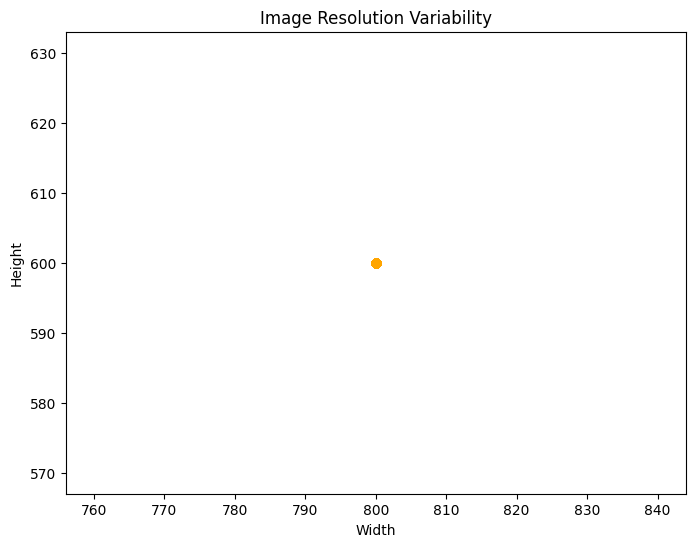

Average Width: 800.00
Average Height: 600.00
Minimum Resolution: 800 x 600
Maximum Resolution: 800 x 600


In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define dataset path
dataset_path = train_dir

# Get all image paths
image_paths = [
    os.path.join(root, file)
    for root, _, files in os.walk(dataset_path)
    for file in files if file.lower().endswith(('.jpg', '.png'))
]

print(f"Number of images found: {len(image_paths)}")  # Debugging

# Analyze dimensions
dimensions = []
for img_path in image_paths:
    try:
        with Image.open(img_path) as img:
            dimensions.append(img.size)
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")

# Ensure dimensions list is not empty
if dimensions:
    widths, heights = zip(*dimensions)

    # Plot resolution variability
    plt.figure(figsize=(8, 6))
    plt.scatter(widths, heights, alpha=0.5, color="orange")
    plt.title("Image Resolution Variability")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.show()

    # Print summary statistics
    print(f"Average Width: {sum(widths) / len(widths):.2f}")
    print(f"Average Height: {sum(heights) / len(heights):.2f}")
    print(f"Minimum Resolution: {min(widths)} x {min(heights)}")
    print(f"Maximum Resolution: {max(widths)} x {max(heights)}")
else:
    print("No valid image dimensions found.")



Check duplicate Images

In [6]:
import hashlib

# Generate hash for each image
def hash_image(image_path):
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = {}
duplicates = []
for img_path in image_paths:
    img_hash = hash_image(img_path)
    if img_hash in hashes:
        duplicates.append((img_path, hashes[img_hash]))
    else:
        hashes[img_hash] = img_path

print(f"Number of duplicate images: {len(duplicates)}")
if duplicates:
    print("Example duplicates:", duplicates[:5])

Number of duplicate images: 0


Check low quality images and remove

In [7]:
import numpy as np
import cv2

low_quality_images = []
for img_path in image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        mean_intensity = np.mean(img)
        std_intensity = np.std(img)
        if mean_intensity < 50 or mean_intensity > 200 or std_intensity < 20:
            low_quality_images.append(img_path)

print(f"Number of low-quality images: {len(low_quality_images)}")
if low_quality_images:
    print("Example low-quality images:", low_quality_images[:5])

# Remove low-quality images
for img_path in low_quality_images:
    try:
        os.remove(img_path)
        print(f"Removed: {img_path}")
    except Exception as e:
        print(f"Error removing {img_path}: {e}")

print(f"Total low-quality images removed: {len(low_quality_images)}")

Number of low-quality images: 13
Example low-quality images: ['/kaggle/input/cassava-leaf-disease-classification/train/Cassava Brown Streak Disease (CBSD)/2666462236.jpg', '/kaggle/input/cassava-leaf-disease-classification/train/Cassava Green Mottle (CGM)/2967206024.jpg', '/kaggle/input/cassava-leaf-disease-classification/train/Cassava Green Mottle (CGM)/2613045307.jpg', '/kaggle/input/cassava-leaf-disease-classification/train/Cassava Green Mottle (CGM)/2151050324.jpg', '/kaggle/input/cassava-leaf-disease-classification/train/Cassava Bacterial Blight (CBB)/2889965946.jpg']
Error removing /kaggle/input/cassava-leaf-disease-classification/train/Cassava Brown Streak Disease (CBSD)/2666462236.jpg: [Errno 30] Read-only file system: '/kaggle/input/cassava-leaf-disease-classification/train/Cassava Brown Streak Disease (CBSD)/2666462236.jpg'
Error removing /kaggle/input/cassava-leaf-disease-classification/train/Cassava Green Mottle (CGM)/2967206024.jpg: [Errno 30] Read-only file system: '/kagg

 Data Preprocessing

In [8]:
import os
from PIL import Image

# Define dataset path and target size
dataset_path = "dataset/"
output_path = "resized_dataset/"
os.makedirs(output_path, exist_ok=True)  # Create output folder if it doesn't exist

TARGET_WIDTH = 224  # Target maximum width
TARGET_HEIGHT = 224  # Target maximum height

# Resize images while maintaining aspect ratio
def resize_image(image, target_width, target_height):
    # Get original dimensions
    original_width, original_height = image.size
    
    # Calculate scale factor
    scale_factor = min(target_width / original_width, target_height / original_height)
    
    # Compute new dimensions
    new_width = int(original_width * scale_factor)
    new_height = int(original_height * scale_factor)
    
    # Resize the image
    resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)
    
    return resized_image

# Process each image
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.png')):
            img_path = os.path.join(root, file)
            try:
                with Image.open(img_path) as img:
                    # Resize the image
                    resized_img = resize_image(img, TARGET_WIDTH, TARGET_HEIGHT)
                    
                    # Create output path preserving the folder structure
                    relative_path = os.path.relpath(img_path, dataset_path)
                    save_path = os.path.join(output_path, relative_path)
                    os.makedirs(os.path.dirname(save_path), exist_ok=True)
                    
                    # Save the resized image
                    resized_img.save(save_path)
                    print(f"Resized and saved: {save_path}")
            except Exception as e:
                print(f"Error resizing image {img_path}: {e}")

In [9]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale pixel values to [0, 1]
    shear_range=0.2,            # Shear transformations
    zoom_range=0.2,             # Zoom transformations
    horizontal_flip=True       # Horizontal flips
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
image_size = (224, 224)
batch_size = 32
# Load the training and test datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 17117 images belonging to 5 classes.
Found 4280 images belonging to 5 classes.


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 2
# Define CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = cnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

# Save the model
cnn_model.save("cnn_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


535/535 ━━━━━━━━━━━━━━━━━━━━ 1017s 2s/step - accuracy: 0.6009 - loss: 1.2311
Epoch 2/2


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


535/535 ━━━━━━━━━━━━━━━━━━━━ 1010s 2s/step - accuracy: 0.6407 - loss: 0.9943


In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pool features to reduce dimensions
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the full model
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
transfer_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_tl = transfer_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

# Unfreeze and fine-tune the base model (optional)
base_model.trainable = True
transfer_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_ft = transfer_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS // 2,
    callbacks=[early_stopping]
)

# Save the model
transfer_model.save("transfer_model.h5")

Epoch 1/2
535/535 ━━━━━━━━━━━━━━━━━━━━ 620s 1s/step - accuracy: 0.6226 - loss: 1.0959 - val_accuracy: 0.6813 - val_loss: 0.8711
Epoch 2/2
535/535 ━━━━━━━━━━━━━━━━━━━━ 607s 1s/step - accuracy: 0.6815 - loss: 0.8770 - val_accuracy: 0.6981 - val_loss: 0.8625
535/535 ━━━━━━━━━━━━━━━━━━━━ 2166s 4s/step - accuracy: 0.6780 - loss: 0.8683 - val_accuracy: 0.6185 - val_loss: 1.2409


In [17]:
# Load the saved model
from tensorflow.keras.models import load_model

model = load_model("transfer_model.h5")  # Replace with your model file

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

134/134 ━━━━━━━━━━━━━━━━━━━━ 94s 660ms/step - accuracy: 0.6303 - loss: 1.2029
Test Loss: 1.2409383058547974
Test Accuracy: 0.6184579730033875


In [18]:
# Get predictions
predictions = model.predict(test_generator)
predicted_classes = predictions.argmax(axis=-1)  # Convert to class indices
true_classes = test_generator.classes  # True labels
class_labels = list(test_generator.class_indices.keys())  # Class names

134/134 ━━━━━━━━━━━━━━━━━━━━ 88s 648ms/step


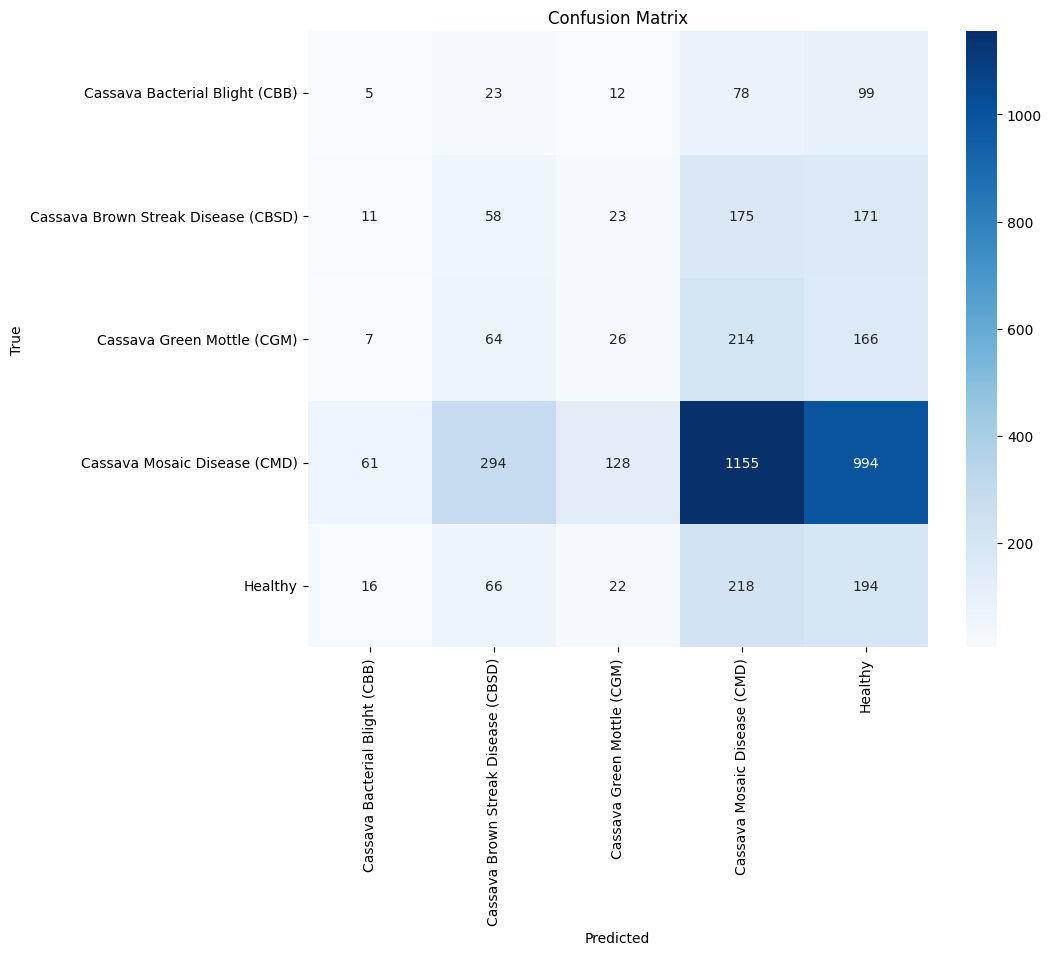

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [20]:
# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.05      0.02      0.03       217
Cassava Brown Streak Disease (CBSD)       0.11      0.13      0.12       438
         Cassava Green Mottle (CGM)       0.12      0.05      0.08       477
       Cassava Mosaic Disease (CMD)       0.63      0.44      0.52      2632
                            Healthy       0.12      0.38      0.18       516

                           accuracy                           0.34      4280
                          macro avg       0.21      0.20      0.19      4280
                       weighted avg       0.43      0.34      0.36      4280



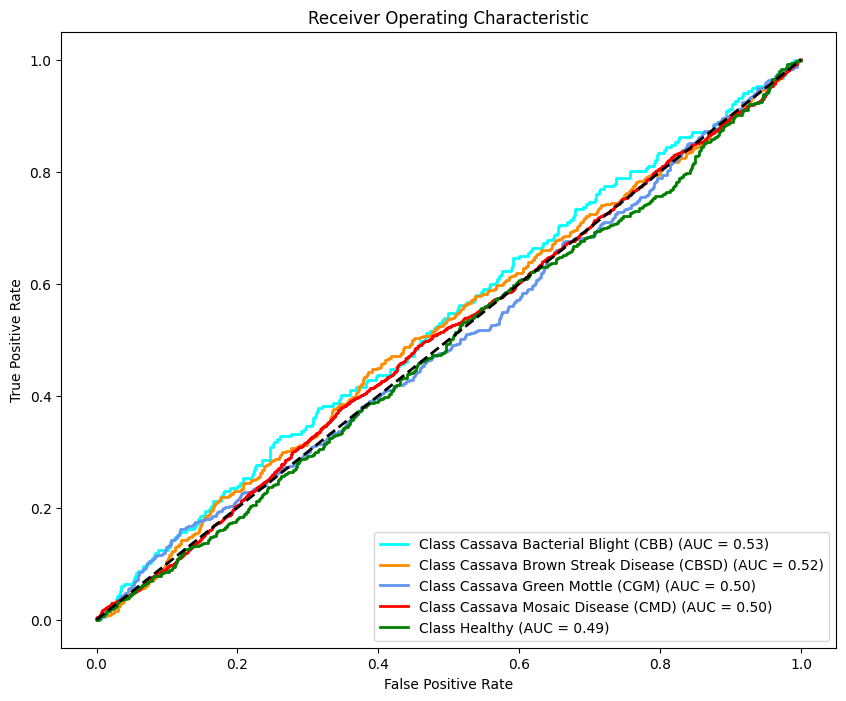

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for ROC computation
y_true = label_binarize(true_classes, classes=range(len(class_labels)))
y_pred = predictions

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green"])
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()
